In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/content/sample_data/cleaned.csv')
df.head()

,Date,NAICS Code,Kind of Business,Sales Million,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1/1/25,NaN,"Retail and food services sales, total",654511.0,NaN,NaN,NaN,NaN,NaN
1,1/1/25,NaN,Retail sales and food services excl motor vehi...,531784.0,NaN,NaN,NaN,NaN,NaN
2,1/1/25,NaN,Retail sales and food services excl gasoline s...,606934.0,NaN,NaN,NaN,NaN,NaN
3,1/1/25,NaN,Retail sales and food services excl motor vehi...,484207.0,NaN,NaN,NaN,NaN,NaN
4,1/1/25,NaN,"Retail sales, total",566662.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns = df.columns.str.strip()

#  rename
df = df[['Date', 'NAICS  Code', 'Kind of Business', 'Sales Million']]
df.columns = ['date', 'naics', 'kind_of_business', 'sales_million_usd']

# Convert data types
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['sales_million_usd', 'date', 'kind_of_business'], inplace=True)
df['naics'] = df['naics'].astype(str).str.strip()
df['sales_million_usd'] = pd.to_numeric(df['sales_million_usd'], errors='coerce')

# Filter for relevant NAICS codes
naics_filter = ['448', '4481', '44812', '44814', '44819', '4482', '4522', '45221']
df = df[df['naics'].isin(naics_filter)]

# Sort and compute 5-year rolling goal
df.sort_values(by=['naics', 'date'], inplace=True)
df['rolling_goal'] = df.groupby('naics')['sales_million_usd']\
                       .transform(lambda x: x.rolling(window=60, min_periods=1).mean().shift(1))

# Calculate goal variance
df['vs_goal'] = df['sales_million_usd'] - df['rolling_goal']
df['percent_diff'] = round((df['vs_goal'] / df['rolling_goal']) * 100, 2)



In [ ]:
df.head()

#drop nan values
df.dropna(inplace=True)
df.head()

,date,naics,kind_of_business,sales_million_usd,rolling_goal,vs_goal,percent_diff
942,2023-02-01,448,Clothing and clothing access. stores,19902.0,18427.000000,1475.000000,8.00
999,2023-03-01,448,Clothing and clothing access. stores,23641.0,19164.500000,4476.500000,23.36
1056,2023-04-01,448,Clothing and clothing access. stores,23422.0,20656.666667,2765.333333,13.39
1113,2023-05-01,448,Clothing and clothing access. stores,25160.0,21348.000000,3812.000000,17.86
1170,2023-06-01,448,Clothing and clothing access. stores,23528.0,22110.400000,1417.600000,6.41


In [ ]:
# Total # of rows where goal is met or exceeded
above_goal_count = df[df['vs_goal'] > 0].shape[0]
total_count = df[df['rolling_goal'].notna()].shape[0]
percent_above_goal = round((above_goal_count / total_count) * 100, 2)

# Top and bottom performing sectors by average % diff
sector_performance = df[df['rolling_goal'].notna()]\
    .groupby(['naics', 'kind_of_business'])['percent_diff']\
    .mean().reset_index().sort_values(by='percent_diff', ascending=False)

top_sector = sector_performance.iloc[0]
bottom_sector = sector_performance.iloc[-1]

print(f" % of periods above goal: {percent_above_goal}%")
print(f" Top sector: {top_sector['kind_of_business']} ({top_sector['percent_diff']}% above)")
print(f" Lowest sector: {bottom_sector['kind_of_business']} ({bottom_sector['percent_diff']}% below)")

 % of periods above goal: 61.54%
 Top sector: Family clothing stores (10.688076923076922% above)
 Lowest sector: Other clothing stores (1.5846153846153848% below)


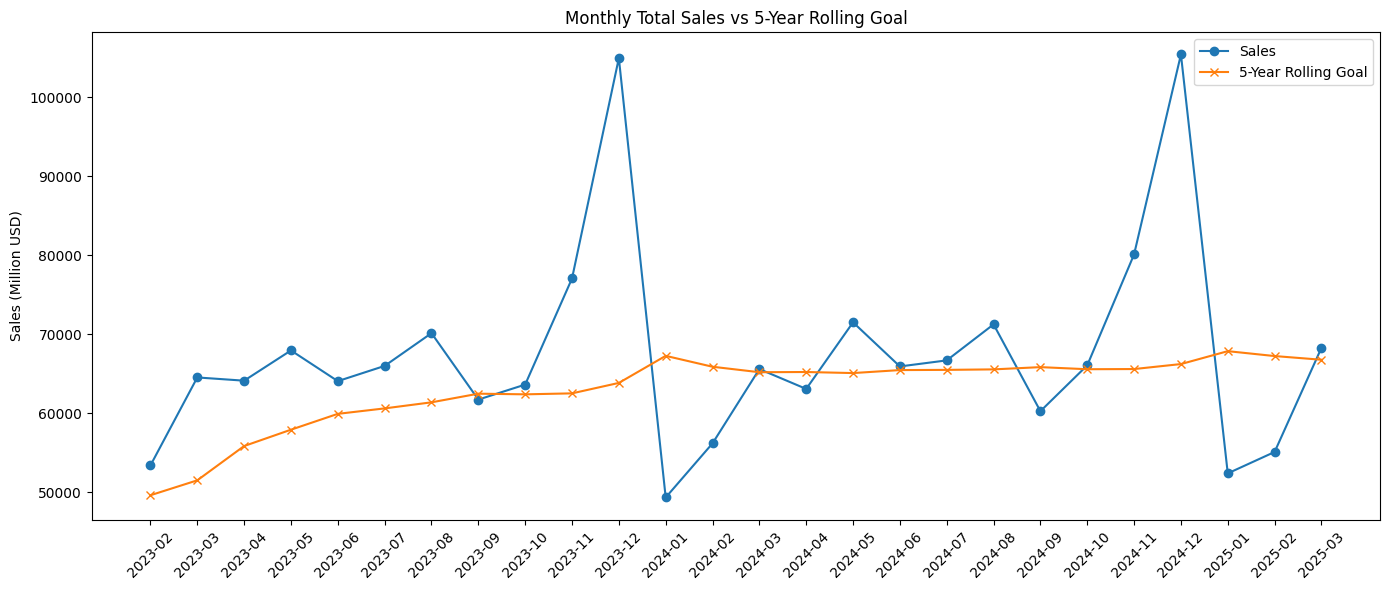

In [ ]:
import matplotlib.pyplot as plt

# Prepare monthly aggregates
monthly = df.copy()
monthly['month'] = monthly['date'].dt.to_period('M').astype(str)
monthly_trend = monthly.groupby('month')[['sales_million_usd', 'rolling_goal']].sum().reset_index()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_trend['month'], monthly_trend['sales_million_usd'], label='Sales', marker='o')
plt.plot(monthly_trend['month'], monthly_trend['rolling_goal'], label='5-Year Rolling Goal', marker='x')
plt.xticks(rotation=45)
plt.title('Monthly Total Sales vs 5-Year Rolling Goal')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.tight_layout()
plt.show()

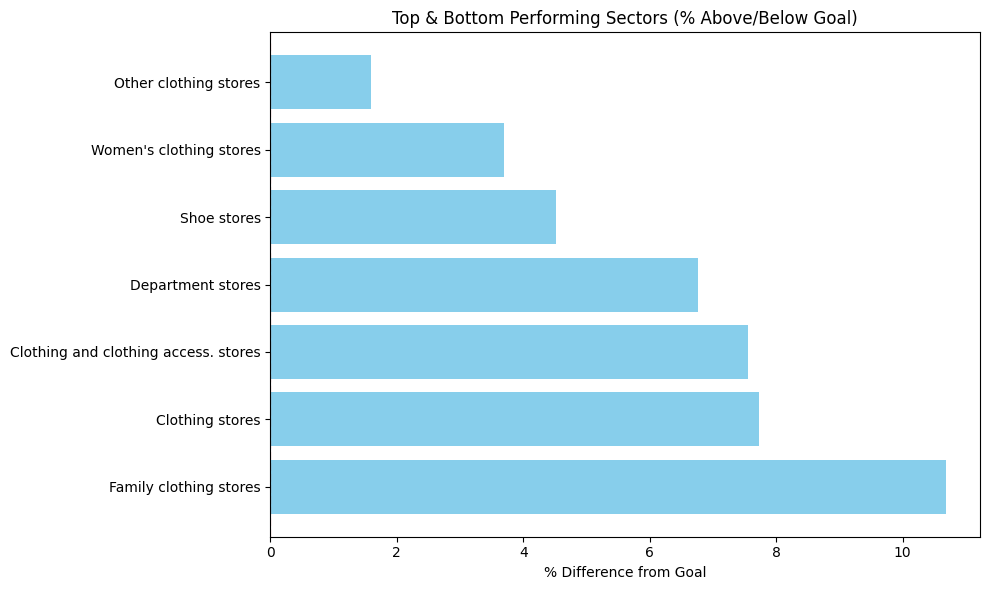

In [ ]:
import matplotlib.pyplot as plt

# Concatenate top and bottom performers
top_5 = sector_performance.head(5)
bottom_5 = sector_performance.tail(5)
top_bottom = pd.concat([top_5, bottom_5], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_bottom['kind_of_business'], top_bottom['percent_diff'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Top & Bottom Performing Sectors (% Above/Below Goal)')
plt.xlabel('% Difference from Goal')
plt.tight_layout()
plt.show()

In [ ]:
# Tableau-style: aggregated diff
total_sales = df['sales_million_usd'].sum()
total_goal = df['rolling_goal'].sum()
tableau_style_percent_diff = round((total_sales - total_goal) / total_goal * 100, 2)
print(f"Tableau-style aggregate percent diff: {tableau_style_percent_diff}%")

Tableau-style aggregate percent diff: 7.11%


In [ ]:
agg_check = df.groupby('naics')[['sales_million_usd', 'rolling_goal']].sum()
agg_check['percent_diff_tableau_style'] = round((agg_check['sales_million_usd'] - agg_check['rolling_goal']) / agg_check['rolling_goal'] * 100, 2)
display(agg_check)

,sales_million_usd,rolling_goal,percent_diff_tableau_style
naics,,,
448,646837.0,603553.249030,7.17
4481,457627.0,426242.246084,7.36
44812,75130.0,72753.033951,3.27
44814,277491.0,251643.059850,10.27
44819,40107.0,39517.183877,1.49
4482,83909.0,80769.610786,3.89
4522,86479.0,81559.519670,6.03
45221,86479.0,81559.519670,6.03


In [ ]:
# saving csv file
df.to_csv('/content/sample_data/retail_sector_analysis_part2.csv', index=False)

In [ ]:
total_sales = df['sales_million_usd'].sum()
print(f"Total Sales: ${total_sales:,.0f}M")

Total Sales: $1,754,059M


In [ ]:
total_variance = df['vs_goal'].sum()
print(f"Total Variance: ${total_variance:,.0f}")

Total Variance: $116,462


In [ ]:
above_goal_count = df[df['vs_goal'] > 0].shape[0]
total_with_goal = df['rolling_goal'].notna().sum()

percent_above_goal = round((above_goal_count / total_with_goal) * 100, 2)
print(f"% Above Goal: {percent_above_goal}%")

% Above Goal: 61.54%


In [ ]:
# Group by sector
agg_by_sector = df.groupby('kind_of_business')[['sales_million_usd', 'rolling_goal']].sum()
agg_by_sector['above_goal'] = agg_by_sector['sales_million_usd'] > agg_by_sector['rolling_goal']

# Calculate %
percent_above_goal_sector_level = round((agg_by_sector['above_goal'].sum() / len(agg_by_sector)) * 100, 2)
print(f"Sector-Level % Above Goal (Tableau-style): {percent_above_goal_sector_level}%")

Sector-Level % Above Goal (Tableau-style): 100.0%
